<h1> AI@SLU Tutorial: Deep Learning to Understand Images</h1>

Welcome to the world's fastest deep dive into deep convolutional neural networks! There are going to be a huge number of specifics in this code that we don't have time to discuss in much depth. If you're interested in the subject matter, I encourage you to sign up for Deep Learning in the Spring, where we'll spend a whole semester on these types of topics!



---



Start off with lots of imports!

We are going to be using the PyTorch Deep Learning Framework (all the imports with "torch" in them).

In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


---

<h2> Defining the Neural Net Class </h2>

Define the neural network, including how many and what type of layers, and what happens to an actual input on the forward pass through the network:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(20, 10) # our output has 10 features -- 1 for each digit
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(-1, 20)
        x = self.fc1(x)
        return F.log_softmax(x)

Create our own instance of this neural net:

In [ ]:
net = Net()

*For what it's worth, in any real world use case I would **highly highly highly highly** recommend using some of off the shelf neural network architecture and focus your time on questions like "how can I get more or better data?", "what are the right data pre-processing steps?" and "what is the right loss function?"*

<h2> Loss Function & Optimizer </h2>

Define our "criterion" (or loss function) and our "optimizer":

* the criterion or loss function is the precise mathematical equation to compute "how wrong is my current network relative to my ground truth labels" (cross entropy loss is the standard for classification problems like "is this picture a dog, cat or camel?")
* the optimizer is the algorithm that actually determines how much to change your network each iteration *based* on the criterion

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


---

<h2> Loading Data </h2>

Okay, so we have our model now, but we don't have any data!

First, we're going to tell PyTorch what to do when it gets data -- specifically to convert it to a "tensor" and then subtract off the mean and divide by the standard deviation (which for convenience we're just setting to 0.5 here).

In [ ]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

Lots of nice people have saved us from having to do the real work of organizing datasets, so we can create our training and testing datasets of handwritten digits by just calling torchvision.datasets.MNIST.

*(PyTorch has lots of already implemented datasets like this, as well as dataset objects that work with your own data on your own computer or server. My most commonly used data loading process is to use torchvision.datasets.ImageFolder to load images from a folder on my server.)*

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

In addition to the data *set* we also need data *loaders* -- programs that tell us exactly how to load our images into batches that get fed through the neural network.

In [ ]:
batch_size = 4 # the number of images that get pushed through the network at a time

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)



So what does our data actually look like??


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert the image to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # pytorch has the channels of the image organized differently than matplotlib expects so flip them around

# get a random training batch
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
print(labels)
imshow(torchvision.utils.make_grid(images))


---

<h2> Training the Network </h2>

Now that we have our network and data, it's time to train!




In [ ]:
# loop over the dataset multiple times
for epoch in range(2):

    # keep track of our loss (error) over a number of batches so we can track how we're doing
    running_loss = 0.0

    # loop over each batch in our training dataset
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)

        # compute loss
        loss = criterion(outputs, labels)

        # backpropogate based on loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')



---

<h2> Evaluation </h2>

Once we've trained, we want to see how well we're doing.

First, let's load just a single batch of images and see how it looks:

In [ ]:
# put the network into "eval" mode (not training)
net.eval()

with torch.no_grad(): # have to set no_grad() in addition to setting eval mode
    # load a single batch from the test loader
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # pass the batch through the network and get the outputs
    outputs = net(images)

    # the predicted class is the argmax of the outputs (sometimes passing through a softmax first)
    _, predicted = torch.max(outputs, 1)

# Show the images that were passed through and their predicted class
imshow(torchvision.utils.make_grid(images))
print(predicted)

We can do the same thing for the entire test dataset, keeping track of our test accuracy:

In [ ]:
correct = 0
total = 0

with torch.no_grad(): # have to set no_grad() in addition to setting eval mode
    # loop over the test data
    for data in testloader:
        images, labels = data
        
        # pass the batch through the network and get the outputs
        outputs = net(images)
        
        # the predicted class is the argmax of the outputs (sometimes passing through a softmax first)
        _, predicted = torch.max(outputs.data, 1)

        # keep track of how many we're getting right
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))



---
<h2> Visual Explainability: Class Activation Mapping </h2>


It's exciting that we have a simple neural network that performs over 9x better than random chance!

What if we want to understand what exactly the network is "looking at" when it makes its prediction?



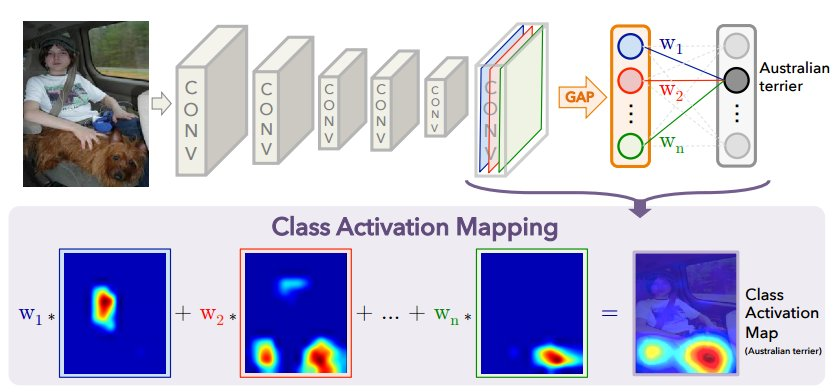

In [ ]:
def returnCAM(last_conv_features, weights, predicted_class):
    # keep track of the dimensions of our last convolutional layer
    num_channels, height, width = last_conv_features.shape

    # take the dot product of the last convolutional layer with the weights that
    # "connect" them to the predicted class
    cam = weights[predicted_class].dot(last_conv_features.reshape((num_channels, height*width)))

    # reshape into an image
    cam = cam.reshape(height, width)

    # normalize to have a min of 0 and a max of 1
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    
    # convert to uint8s (0-255)
    cam_img = np.uint8(255. * cam_img)
    return cam_img

In [ ]:
# in order to make our class activation map, we need to get those weights 
# between the last convolutional layer and the output

params = list(net.parameters())
weights = np.squeeze(params[-2].cpu().data.numpy())

In [ ]:
# loop over out test data again
with torch.no_grad():
    for data in testloader:

        # create a "hook" to grab the activations of the last conv layer
        feature_blobs = []
        def hook_feature(module, input, output):
            data_out = output.cpu().data.numpy()
            feature_blobs.append(data_out)
        hook = net.conv2.register_forward_hook(hook_feature)

        # when we push the batch through the network, the "hook" will put the
        # activations of the last conv layer in feature_blobs
        images, labels = data
        outputs = net(images)

        # make the predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # remove the hook
        hook.remove()
        
        # loop over each image in the batch
        for fb, im, p in zip(feature_blobs[0], images, predicted):
            # create the class activation map for the predicted class
            # or "why did the network think it was the class it predicted"
            cam = returnCAM(fb, weights, p)

            # convert the image back into something that looks like an image
            pixel_vals = np.squeeze(im.detach().cpu().numpy())
            pixel_vals = pixel_vals * 0.5 + 0.5 # undo the normalization
            pixel_vals *= 255. # PIL expects images between 0 and 255
            rgb = np.dstack((pixel_vals, pixel_vals, pixel_vals))
            img = Image.fromarray(rgb.astype('uint8'))
            img = img.resize((256,256))
            
            # convert the class activation map to a heatmap
            cm = plt.get_cmap('jet')
            colored_overlay = cm(cam)
            colored_overlay = (colored_overlay * 255).astype('uint8')[:,:,:3]
            overlay = Image.fromarray(colored_overlay)
            overlay = overlay.resize((256,256), Image.NEAREST)

            # combine the image and the heatmap
            result = np.array(overlay) * 0.3 + np.array(img) * 0.7

            # make a figure
            plt.imshow(Image.fromarray(result.astype('uint8')))
            title_str = 'Predicted: %s' % (p.detach())
            plt.title(title_str)
            plt.show()